### Imports

In [97]:
import sys
sys.path.append('../src')

import data_utils


import matplotlib.pyplot  as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import platform
import cv2
import tensorflow as tf
import IPython.display as display
import os


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from skimage import io, feature, util, color
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, confusion_matrix, precision_score, recall_score, f1_score
from skimage.io import imread
from sklearn.utils import class_weight
from tensorflow import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight


import warnings
warnings.filterwarnings("ignore")

# 3. Data Preprocessing
----

In [62]:
# Read data
main_data = pd.read_csv("../data/raw/data_labels_mainData.csv")
extra_data = pd.read_csv("../data/raw/data_labels_extraData.csv")

# Read patient images 
image_folder = "../data/raw/patch_images"
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]

### 3.2 Train-Val-Test Split
----

Because we observed the similarity between the images from a same patienID, we conclude that if we include images of the same patient in both the training and testing sets, data leakage might be introduced, since the model may simply memorize the images of the patients in the training set rather than learning to recognize general patterns that can be applied to new, unseen patients. To avoid this we ensure that there is no overlap between the images of patients in the sets by spliting by patientID.

Splitting the data by patient ID can also make easier to add new data to the model. When we split the data by patient ID, we can train the model on a subset of the data and then evaluate its performance on a separate subset of the data. If we later acquire new data from additional patients, we can simply add it to the training set and retrain the model. The model will then learn to recognize patterns specific to these new patients and should improve its performance on new, unseen images.

In [63]:
def split_dataset(main_data, train_ratio, val_ratio):
    """
    Split the main_data DataFrame into training, validation, and testing sets based on the patientID column.

    Parameters:
    main_data (DataFrame): the DataFrame containing the image data
    train_ratio (float): the proportion of data to allocate to the training set (e.g., 0.7 for 70%)
    val_ratio (float): the proportion of data to allocate to the validation set (e.g., 0.15 for 15%)

    Returns:
    train_data (DataFrame): the subset of main_data containing the training data
    val_data (DataFrame): the subset of main_data containing the validation data
    test_data (DataFrame): the subset of main_data containing the testing data
    """
    np.random.seed(88)
    unique_patients = np.unique(main_data['patientID'])
    np.random.shuffle(unique_patients)

    train_patients, val_test_patients = np.split(unique_patients, [int(len(unique_patients)*train_ratio)])
    val_patients, test_patients = np.split(val_test_patients, [int(len(val_test_patients)*val_ratio)])
    
    train_data = main_data[main_data['patientID'].isin(train_patients)]
    val_data = main_data[main_data['patientID'].isin(val_patients)]
    test_data = main_data[main_data['patientID'].isin(test_patients)]

    return train_data, val_data, test_data

In [64]:
train_data, val_data, test_data = split_dataset(main_data, train_ratio=0.7, val_ratio=0.55)

print("Train: ", train_data.shape)
print("Val:   ", val_data.shape)
print("Test:  ",test_data.shape)
print()

Train:  (7360, 6)
Val:    (1241, 6)
Test:   (1295, 6)



We conduct a **Sanity check** to ensure that no patient IDs are present in more than one dataset (train, validation, or test). If any IDs are present in more than one dataset, it could lead to data leakage and affect the accuracy of the model's evaluation.

In [65]:
train_patients = set(train_data['patientID'].unique())
val_patients = set(val_data['patientID'].unique())
test_patients = set(test_data['patientID'].unique())

try:
    assert len(train_patients.intersection(val_patients)) == 0
    assert len(train_patients.intersection(test_patients)) == 0
    assert len(val_patients.intersection(test_patients)) == 0
    print("No patient ID is present in more than one dataset.")
except AssertionError:
    print("Error: some patient IDs are present in multiple datasets.")

No patient ID is present in more than one dataset.


### 3.3 Evaluating the distribution in our splits
----

In [66]:
def plot_dataset_distributions(train_data, val_data, test_data, class_columns):
    """
    Plot the distributions of the given columns for the three datasets.

    Parameters:
    train_data (DataFrame): the training dataset
    val_data (DataFrame): the validation dataset
    test_data (DataFrame): the testing dataset
    class_columns (list): a list of column names to plot distributions for

    Returns:
    None
    """
    fig, axs = plt.subplots(len(class_columns), 3, figsize=(15, 5*len(class_columns)))

    for i, col in enumerate(class_columns):
        axs[i][0].hist(train_data[col], bins=10, color='blue')
        axs[i][0].set_title(f"Training Set - {col} Distribution")
        axs[i][1].hist(val_data[col], bins=10, color='green')
        axs[i][1].set_title(f"Validation Set - {col} Distribution")
        axs[i][2].hist(test_data[col], bins=10, color='orange')
        axs[i][2].set_title(f"Testing Set - {col} Distribution")
    fig.suptitle("Distribution of Dataset Classes for each set.", fontsize=16)
    plt.show()

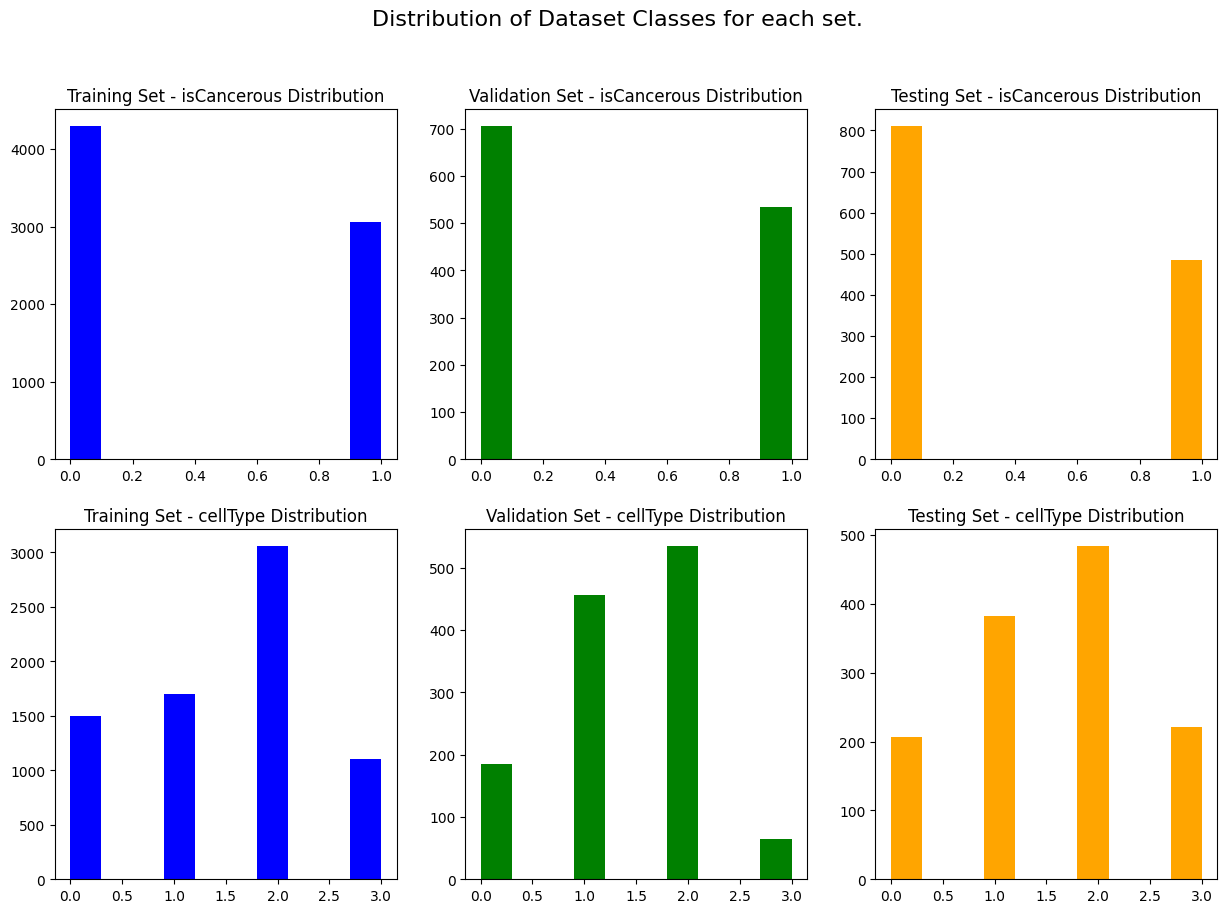

In [67]:
class_columns = ['isCancerous', 'cellType']
plot_dataset_distributions(train_data, val_data, test_data, class_columns)

In [68]:
train_data['cellType'].value_counts()

2    3060
1    1703
0    1496
3    1101
Name: cellType, dtype: int64

Check if all images really have a consistent width and height:

### 3.4 Image Preprocessing
----


We should consider, while the model may learn to recognize specific patterns that are unique to the images from the patients in the training set, these features may not apply to images from new patients. To address this, we can consider using techniques to address the potential for overfitting, such as regularization or data augmentation to artificially increase the variation in the images. These techniques can help ensure that the model learns to recognize general patterns that are not unique to specific patients, and can help improve its ability to generalize to new, unseen patients.

To prepare the image data for use in a CNN, we will perform image preprocessing steps such as resizing, normalization, and augmentation, to improve the quality and quantity of the data.  Then pass the preprocessed images through the CNN model, which would learn to extract features from the images and classify them based on their cellType or isCancerous.


In [69]:
def generate_data_generators(data, image_folder, target_size, batch_size):
    datagen = ImageDataGenerator(
        rescale=1./255,
        data_format='channels_last'
    )
    
    generator = datagen.flow_from_dataframe(
        data,
        directory=image_folder,
        x_col='ImageName',
        y_col='cellType',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    return generator


In [70]:
def prepare_data(image_folder, train_data, val_data, test_data, target_size, batch_size):
    train_generator = generate_data_generators(train_data, image_folder, target_size, batch_size)
    val_generator = generate_data_generators(val_data, image_folder, target_size, batch_size)
    test_generator = generate_data_generators(test_data, image_folder, target_size, batch_size)

    return train_generator, val_generator, test_generator

In [71]:
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)
test_data['cellType'] = test_data['cellType'].astype(str)

In [72]:
train_generator, val_generator, test_generator \
    = prepare_data(
    image_folder=image_folder,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    target_size=(27, 27),
    batch_size=32
)

Found 7360 validated image filenames belonging to 4 classes.
Found 1241 validated image filenames belonging to 4 classes.
Found 1295 validated image filenames belonging to 4 classes.


We make use of the function to preprocess_data to preprocess our data. This function creates data generators for the train, validation, and test sets using the ImageDataGenerator class from Keras. The generators preprocess the image data by applying various techniques. The training set is augmented with various transformations such as rotation, width shift, height shift, shear, zoom, and horizontal flip, whereas the validation and test sets are only rescaled. The rescale parameter scales the pixel values of the images to a range of 0 to 1.  

 The output dictionary contains the generators for the train, validation, and test sets, as well as the number of samples in each set. We will use these generators to train our model.

# 4. Model Evaluation Set-up
----

To evaluate out baseline model's performance on the test set, we will be using appropriate evaluation metrics for multi-class classification. 

Common metrics to considered:

- **Accuracy**: Calculate the overall accuracy of the model, which measures the proportion of correctly classified samples.
- **Precision**: Compute the precision for each class, which measures the proportion of correctly predicted samples among the predicted samples for that class.
- **Recall**: Calculate the recall for each class, which measures the proportion of correctly predicted samples among the actual samples of that class.
- **F1-Score**: Compute the F1-score for each class, which is the harmonic mean of precision and recall and provides a balanced measure of a model's performance.

In [73]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# 5. Model Development
----

## 5.1 Baseline Model
----

The model architecture below is based on the widely used convolutional neural network (CNN) modelVGG (Visual Geometry Group) network architecture. The VGG network is known for its simplicity and effectiveness in image classification tasks.

The model presented follows the general structure of the VGG network, consisting of several convolutional layers with smaller filter sizes, and by max-pooling layers to reduce the spatial dimensions. It also includes fully connected layers at the end to perform the final classification. 

- INPUT_DIM: The input shape of the model is (27, 27, 3), which indicates that the input images have a height and width of 27 pixels and three color channels (RGB).

- HIDDEN_LAYER_DIM: The hidden layer dimension is set to 256, which means that the fully connected layer in the model has 256 neurons. This value determines the capacity of the hidden layer to capture and represent complex patterns in the data.

- OUTPUT_CLASSES: The number of output classes in the model is 4, designed to perform a multi-class classification task with four distinct classes.

The three VGG blocks help capture hierarchical features and a fully connected layer with 256 neurons for classification.

In [74]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

model_BASE_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

**Model Summary**


In [75]:
model_base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

### 5.1.1 Training of model_BASE_1
----

In [76]:
model_BASE_1.compile(optimizer='SGD',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['categorical_accuracy', 
                            tf.keras.metrics.Precision(), 
                            tf.keras.metrics.Recall()
                            ])

In [77]:
history = model_BASE_1.fit(train_generator, 
                         steps_per_epoch=len(train_generator),
                         validation_data=val_generator,
                         validation_steps=len(val_generator),
                         epochs=100,
                         verbose=0)

### 5.1.2 model_BASE_1 Evaluation
----

In [78]:
def print_evaluation_metrics(model, data_generator):
    evaluation_results = model.evaluate(data_generator)
    accuracy = evaluation_results[1]
    precision = evaluation_results[2]
    recall = evaluation_results[3]
    f1_score = (2 * precision * recall) / (precision + recall)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1_score)

In [79]:
print_evaluation_metrics(model_BASE_1, val_generator)

39/39 [==============================] - 0s 11ms/step - loss: 2.6720 - categorical_accuracy: 0.6898 - precision_1: 0.6917 - recall_1: 0.6890
Accuracy: 0.6897662878036499
Precision: 0.6917476058006287
Recall: 0.6889604926109314
F1-Score: 0.6903512361564682


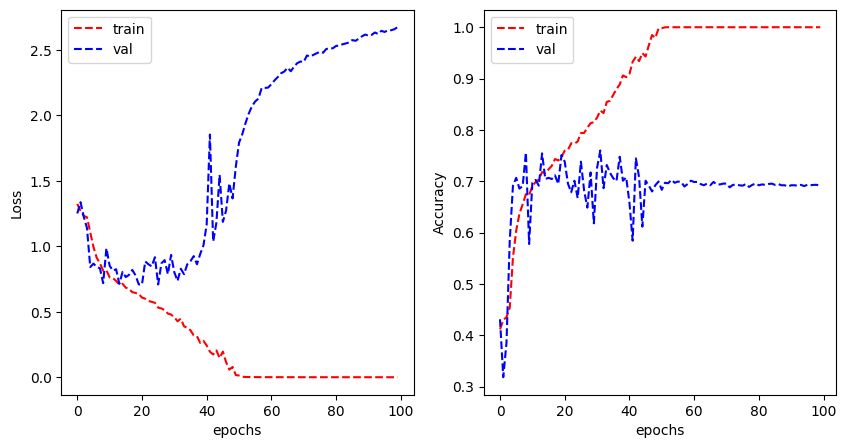

In [80]:
plot_learning_curve(history.history['loss'], 
                    history.history['val_loss'], 
                    history.history['categorical_accuracy'], 
                    history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### 5.1.3 model_BASE_1 Model Predictions
----

The class imbalance in the training data could be one of the reasons why the model tends to overpredict label 2. The class imbalance means that one or more classes have significantly more samples than others, which can lead to biased predictions. To address this issue, we can try data augmentation.

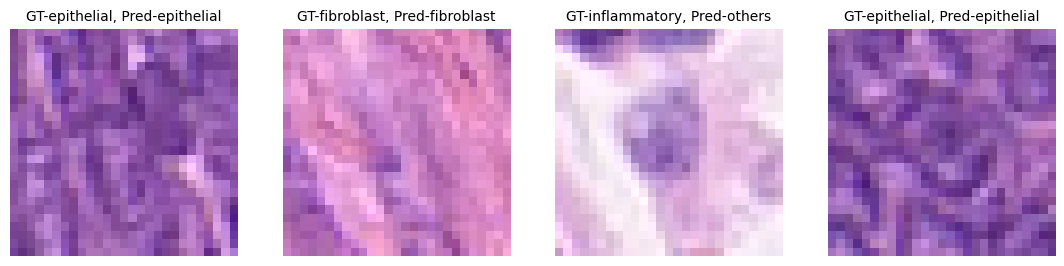

In [81]:
label_map = {'fibroblast':0 , 'inflammatory': 1, 'epithelial': 2, 'others': 3}

d_inv = {v: k for k, v in label_map.items()}
plt.figure(figsize=(17,3))
batches = 0
for x,y in val_generator:
        batches = batches + 1
        y_hat = model_base.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(np.squeeze(x[0]))
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])]), fontsize=10)
            
        else:
            break
        
        plt.axis('off')

In [82]:
def calculate_confusion_matrix_and_f1(y_true, y_prediction):
    y_pred_classes = np.argmax(y_prediction, axis=1)
    confusion_mat = confusion_matrix(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='macro')
    recall = recall_score(y_true, y_pred_classes, average='macro')
    f1 = f1_score(y_true, y_pred_classes, average='macro')
    
    print('Confusion Matrix:')
    print(confusion_mat)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1)
    
    return confusion_mat

def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="viridis", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def evaluate_model(model_base, val_generator):
    y_prediction = model_base.predict(val_generator)
    y_true = val_generator.labels
    confusion_matrix_result = calculate_confusion_matrix_and_f1(y_true, y_prediction)
    plot_confusion_matrix(confusion_matrix_result)
    return confusion_matrix_result

39/39 [==============================] - 0s 5ms/step
Confusion Matrix:
[[ 38  47  78  22]
 [120 120 175  42]
 [116 142 222  55]
 [ 20  11  28   5]]
Precision: 0.24648154249835635
Recall: 0.24026643333155545
F1-Score: 0.23712033651791642


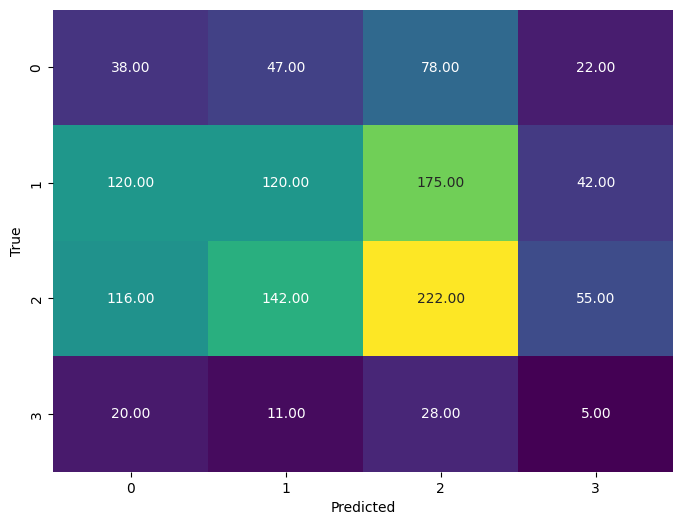

In [83]:
confusion_matrix_result = evaluate_model(model_BASE_1, val_generator)

## 5.2 Data Augmentation
----

We generate additional training examples by applying various transformations to the existing images, such as rotation, scaling, flipping, or shifting. This can help to balance the representation of different classes in our data and increase the diversity of examples for each class.

In [84]:
datagen_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    fill_mode='nearest',
    data_format='channels_last'
)

In [85]:
train_generator_aug = datagen_augmentation.flow_from_dataframe(
    train_data,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=32,
    class_mode='categorical'
)

Found 7360 validated image filenames belonging to 4 classes.


### 5.2.1 Training of model_BASE_1 with Augmented Data
----

In [86]:
history = model_BASE_1.fit(train_generator_aug, 
                         validation_data=val_generator,
                         validation_steps=len(val_generator), 
                         epochs=100, 
                         verbose=0)

### 5.2.2 Evaluation model_BASE_1 after Augmentation
----

In [87]:
print_evaluation_metrics(model_BASE_1, val_generator)

39/39 [==============================] - 0s 9ms/step - loss: 0.7332 - categorical_accuracy: 0.7486 - precision_1: 0.7870 - recall_1: 0.7115
Accuracy: 0.7485898733139038
Precision: 0.7869875431060791
Recall: 0.7115229368209839
F1-Score: 0.7473550507829921


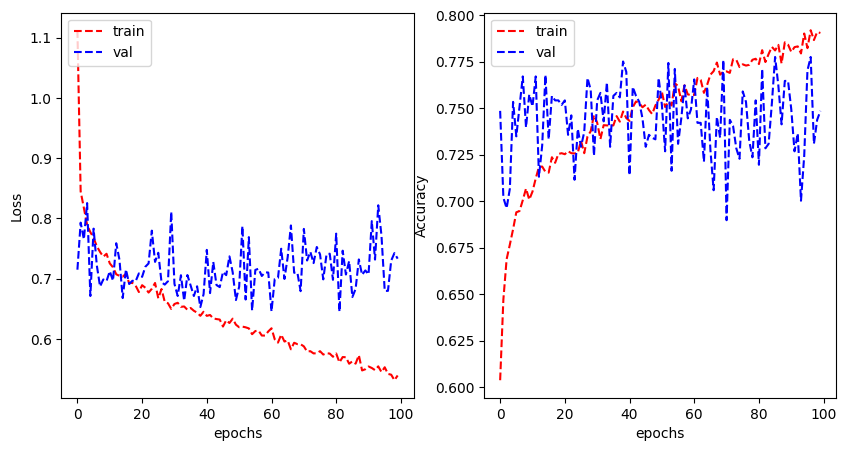

In [88]:
plot_learning_curve(history.history['loss'], 
                    history.history['val_loss'], 
                    history.history['categorical_accuracy'], 
                    history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### 5.2.3 model_BASE_1 Predictions after Data Augmentation
----

Data augmentation didn't address the issue of class imbalance. From the values in the matrix, it appears that the model is still biased towards predicting class 2, even after data augmentation. Since the imbalance in the original dataset still persists after applying data augmentation, we see that althiugh slightly improved, the model has learnt to rely on certain patterns or features that are more prevalent in the majority class (class 2), leading to an increased tendency to predict class 2. 

The model is not able to sufficiently differentiate between the classes, particularly for the underrepresented classes (labels 0 and 3). This indicates that additional steps need to be taken to address the class imbalance and improve the model's performance.

39/39 [==============================] - 0s 4ms/step
Confusion Matrix:
[[ 36  64  72  13]
 [ 68 153 210  26]
 [ 87 187 222  39]
 [  8  23  30   3]]
Precision: 0.24799642851474124
Recall: 0.2478037470402313
F1-Score: 0.24759364927434102


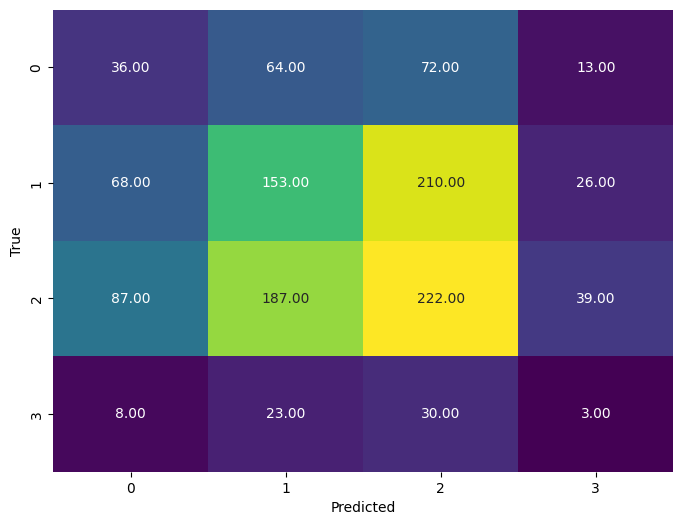

In [89]:
confusion_matrix_result = evaluate_model(model_BASE_1, val_generator)

## 5.3 Class Weights
----


The class weights are calculated based on the distribution of the classes in the dataset. The purpose of assigning different weights to each class is to account for class imbalances during training. The weights are inversely proportional to the class frequencies, which means that the classes with fewer samples will have higher weights, and the classes with more samples will have lower weights.

In this case, we have seen that the class with label 2 has the highest frequency of 3060 in our training, so it is assigned the lowest weight of 0.601. The class with label 1 has a frequency of 1703 and is assigned a weight of 1.080. The class with label 0 has a frequency of 1496 and is assigned a weight of 1.229. Finally, the class with label 3 has the lowest frequency of 1101 and is assigned the highest weight of 1.671.

In [101]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.2299465240641712, 1: 1.080446271285966, 2: 0.6013071895424836, 3: 1.6712079927338783}


### 5.3.1 model_BASE_1 training with Weight Class
----

By using these class weights during training, the model will pay more attention to the underrepresented classes and prevent the dominant classes from overpowering the learning process. This helps in achieving a better balance in the model's predictions for each class.

In [91]:
history = model_BASE_1.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    verbose=0
)


Epoch 1/100
230/230 [==============================] - 4s 16ms/step - loss: 0.4885 - categorical_accuracy: 0.8302 - precision_1: 0.8593 - recall_1: 0.7997 - val_loss: 0.7426 - val_categorical_accuracy: 0.7317 - val_precision_1: 0.7932 - val_recall_1: 0.6769
Epoch 2/100
230/230 [==============================] - 4s 16ms/step - loss: 0.4110 - categorical_accuracy: 0.8561 - precision_1: 0.8818 - recall_1: 0.8299 - val_loss: 1.0424 - val_categorical_accuracy: 0.5898 - val_precision_1: 0.6258 - val_recall_1: 0.5471
Epoch 3/100
230/230 [==============================] - 4s 16ms/step - loss: 0.3386 - categorical_accuracy: 0.8871 - precision_1: 0.9066 - recall_1: 0.8696 - val_loss: 1.0153 - val_categorical_accuracy: 0.6358 - val_precision_1: 0.6696 - val_recall_1: 0.6044
Epoch 4/100
230/230 [==============================] - 4s 17ms/step - loss: 0.2734 - categorical_accuracy: 0.9073 - precision_1: 0.9204 - recall_1: 0.8933 - val_loss: 1.0937 - val_categorical_accuracy: 0.6414 - val_precision_1

### 5.3.2 Evaluation
----

The loss and accuracy curves of our model do not even touch or converge, the plot suggests that there may be deeper issues affecting the training process.

In [102]:
print_evaluation_metrics(model_BASE_1, val_generator)

39/39 [==============================] - 1s 12ms/step - loss: 2.8749 - categorical_accuracy: 0.6785 - precision_1: 0.6818 - recall_1: 0.6785
Accuracy: 0.678485095500946
Precision: 0.6817813515663147
Recall: 0.678485095500946
F1-Score: 0.6801292297190098


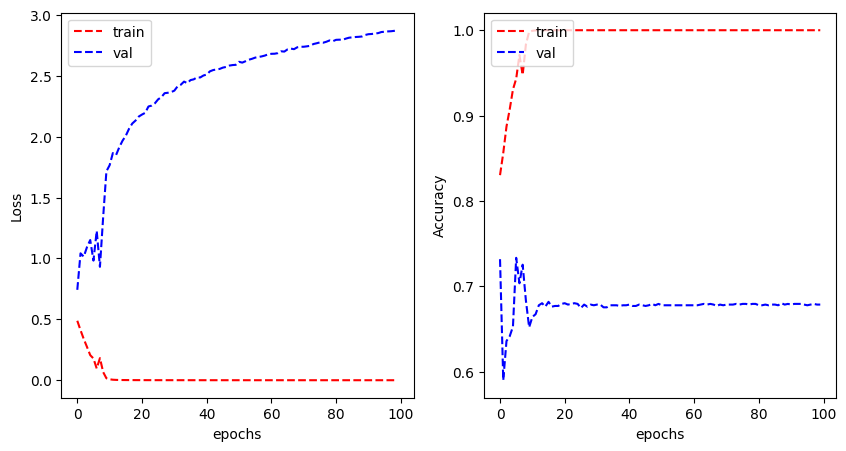

In [92]:
plot_learning_curve(history.history['loss'], 
                    history.history['val_loss'], 
                    history.history['categorical_accuracy'], 
                    history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## 5.4 Drop Out and Batch Normalization
----

We decide to modify our model architecture by applying regularization techniques, we add dropout and batch normalization layers. In this updated architecture, dropout layers with a specified dropout rate (e.g., 0.25 or 0.5) have been added after certain convolutional and dense layers. These dropout layers might help regularize the model by randomly dropping out a fraction of the neurons during training, reducing overfitting. Additionally, batch normalization layers have been inserted after each convolutional layer to normalize the activations and further improve the model's generalization capabilities.

In [104]:
model_BASE_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout layer for regularization
    tf.keras.layers.BatchNormalization(),  # Batch normalization layer
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout layer for regularization
    tf.keras.layers.BatchNormalization(),  # Batch normalization layer
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout layer for regularization
    tf.keras.layers.BatchNormalization(),  # Batch normalization layer
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
    tf.keras.layers.BatchNormalization(),  # Batch normalization layer
    
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])


In [ ]:
model_BASE_1.compile(optimizer='SGD',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['categorical_accuracy', 
                            tf.keras.metrics.Precision(), 
                            tf.keras.metrics.Recall()
                            ])

history = model_BASE_1.fit(train_generator, 
                         steps_per_epoch=len(train_generator),
                         validation_data=val_generator,
                         validation_steps=len(val_generator),
                         epochs=100,
                         verbose=0)